# Energy Calculation Check

Check that energy values match NIST.

In [1]:
import math
import random

def read_xyz(filepath):
    """
    Reads coordinates from an xyz file.
    
    Parameters
    ----------
    filepath : str
       The path to the xyz file to be processed.
       
    Returns
    -------
    atomic_coordinates : list
        A two dimensional list containing atomic coordinates
    
    box_length : float
        The length of one side of the box.
    """
    
    with open(filepath) as f:
        box_length = float(f.readline().split()[0])
        num_atoms = float(f.readline())
        coordinates = f.readlines()
    
    atomic_coordinates = []
    
    for atom in coordinates:
        split_atoms = atom.split()
        
        float_coords = []
        
        # We split this way to get rid of the atom label.
        for coord in split_atoms[1:]:
            float_coords.append(float(coord))
            
        atomic_coordinates.append(float_coords)
        
    
    return atomic_coordinates, box_length

def calculate_distance(coord1, coord2, box_length=None):
    """
    Calculate the distance between two 3D coordinates.
    
    Parameters
    ----------
    coord1, coord2: list
        The atomic coordinates
    
    Returns
    -------
    distance: float
        The distance between the two points.
    """
    
    distance = 0
    for i in range(3):
        dim_dist = (coord1[i] - coord2[i]) 
        
        if box_length:
            dim_dist = dim_dist - box_length * round(dim_dist / box_length)
        
        dim_dist = dim_dist**2
        distance += dim_dist
    
    distance = math.sqrt(distance)
    return distance

def calculate_LJ(r_ij):
    """
    The LJ interaction energy between two particles.

    Computes the pairwise Lennard Jones interaction energy based on the separation distance in reduced units.

    Parameters
    ----------
    r_ij : float
        The distance between the particles in reduced units.
    
    Returns
    -------
    pairwise_energy : float
        The pairwise Lennard Jones interaction energy in reduced units.

    Examples
    --------
    >>> calculate_LJ(1)
    0

    """
    
    r6_term = math.pow(1/r_ij, 6)
    r12_term = math.pow(r6_term, 2)
    
    pairwise_energy = 4 * (r12_term - r6_term)
    
    return pairwise_energy

## Add your group's tail correction function
def calculate_tail_correction(num_particles, cutoff, box_length):
    """
    Calculate the long range tail correction
    """
    
    const1 = (8 * math.pi * num_particles ** 2) / (3 * box_length ** 3)
    const2 = (1/3) * (1 / cutoff)**9 - (1 / cutoff) **3
    
    return const1 * const2

def calculate_total_energy(coordinates, cutoff, box_length=None):
    """
    Calculate the total Lennard Jones energy of a system of particles.
    
    Parameters
    ----------
    coordinates : list
        Nested list containing particle coordinates.
        
    Returns
    -------
    total_energy : float
        The total Lennard Jones energy.
    """
    
    total_energy = 0
    num_atoms = len(coordinates)
    
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            #print(f"Comparing {i} and {j}")
            dist_ij = calculate_distance(coordinates[i], coordinates[j], box_length)
            if dist_ij< cutoff:
                particle_energy = calculate_LJ(dist_ij)
                total_energy += particle_energy
            
    return total_energy

In [2]:
## Read in first sample configuration file here
filepath = "lj_sample_configurations/lj_sample_config_periodic1.txt"

sample_coords, box_length = read_xyz(filepath)

In [3]:
## Check total energy here
total_energy = calculate_total_energy(sample_coords, 3, 10)
calculate_tail_correction(len(sample_coords), 3, 10)

-198.4888837441566

In [4]:
print(total_energy)

-4351.540194543858


In [5]:
def accept_or_reject(delta_U, beta):
    """
    Accept or reject a move based on the Metropolis criterion.
    
    Parameters
    ----------
    delta_U : float
        The change in energy for moving system from state m to n.
    beta : float
        1/temperature
    
    Returns
    -------
    bool
        Whether the move is accepted.
    """
    
    if delta_U <= 0.0:
        accept = True
    else:
        # Generate a random number on (0,1)
        random_number = random.random()
        p_acc = math.exp(-beta*delta_U)
        
        if random_number < p_acc:
            accept = True
        else:
            accept = False
    
    return accept

def calculate_pair_energy(coordinates, i_particle, box_length, cutoff):
    """
    Calculate the interaction energy of a particle with its environment (all other particles in the system)
    
    Parameters
    ----------
    coordinates : list
        The coordinates for all the particles in the system.
    i_particle : int
        The particle number for which to calculate the energy.
    box_length : float
        The length of the simulation box. Assumes cubic box.
    cutoff : float
        The simulation cutoff. Beyond this distances, interactions are not calculated.
    
    Returns
    -------
    float
        The pairwise interaction energy of the ith particles with all other particles in the system.
    """
    
    e_total = 0.0
    i_position = coordinates[i_particle]
    
    num_atoms = len(coordinates)
    
    for j_particle in range(num_atoms):
        if i_particle != j_particle:
            
            j_position = coordinates[j_particle]
            rij = calculate_distance(i_position, j_position, box_length)
            
            if rij < cutoff:
                e_pair = calculate_LJ(rij)
                e_total += e_pair
                
                
    return e_total

In [6]:
import time

start = time.time()

# Read or generate initial coordinates
coordinates, box_length = read_xyz('lj_sample_configurations/lj_sample_config_periodic1.txt')

# Set simulation parameters
reduced_temperature = 0.9
num_steps = 10
max_displacement = 0.1
cutoff = 3
freq = 1000

# Calculated quantities
beta = 1 / reduced_temperature
num_particles = len(coordinates)

# Energy calculations
total_energy = calculate_total_energy(coordinates, cutoff, box_length)
print(total_energy)
tail_correction = calculate_tail_correction(num_particles, cutoff, box_length)
print(tail_correction)

total_energy += tail_correction

random.seed(0)
for step in range(num_steps):
    
    # 1. Randomly pick one of the particles
    random_particle = random.randrange(num_particles)
    
    # 2. Calculate the interaction energy of the selected particle with the system and store this value.
    # current_energy = calculate_total_energy(coordinates, random_particle, box_length, cutoff)
    current_energy = calculate_total_energy(coordinates, cutoff, box_length)
    
    # 3. Generate a random x, y, z displacement
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # 4. Modify the coordinate of Nth particle by generated displacements.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # 5. Calculate the interaction energy of the moved particle with the system and store this value.
    # proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    proposed_energy = calculate_total_energy(coordinates, cutoff, box_length)
    delta_energy = proposed_energy - current_energy
    
    # 6. Calculate if we accept the move based on energy difference
    accept = accept_or_reject(delta_energy, beta)
    
    # 7. if accept, move the particle
    if accept:
        total_energy += delta_energy
    else:
        # Move is not accepted, roll back coordinates
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # 8. print the energy if setp is multiple of freq
    if step % freq == 0:
        print(step, total_energy/num_particles)
        
end = time.time()

print(f"Elapsed Time: {end - start}")

-4351.540194543858
-198.4888837441566
0 -5.688620070545913
Elapsed Time: 5.140450954437256


In [7]:
import time

start = time.time()

# Read or generate initial coordinates
coordinates, box_length = read_xyz('lj_sample_configurations/lj_sample_config_periodic1.txt')

# Set simulation parameters
reduced_temperature = 0.9
freq = 100
num_steps = 1000 * freq + 1
max_displacement = 0.1
cutoff = 3

# Calculated quantities
beta = 1 / reduced_temperature
num_particles = len(coordinates)

# Energy calculations
total_energy = calculate_total_energy(coordinates, cutoff, box_length)
print(total_energy)
tail_correction = calculate_tail_correction(num_particles, cutoff, box_length)
print(tail_correction)

total_energy += tail_correction

frames = []

random.seed(0)
for step in range(num_steps):
    
    # 1. Randomly pick one of the particles
    random_particle = random.randrange(num_particles)
    
    # 2. Calculate the interaction energy of the selected particle with the system and store this value.
    current_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    # current_energy = calculate_total_energy(coordinates, cutoff, box_length)
    
    # 3. Generate a random x, y, z displacement
    x_rand = random.uniform(-max_displacement, max_displacement)
    y_rand = random.uniform(-max_displacement, max_displacement)
    z_rand = random.uniform(-max_displacement, max_displacement)
    
    # 4. Modify the coordinate of Nth particle by generated displacements.
    coordinates[random_particle][0] += x_rand
    coordinates[random_particle][1] += y_rand
    coordinates[random_particle][2] += z_rand
    
    # 5. Calculate the interaction energy of the moved particle with the system and store this value.
    proposed_energy = calculate_pair_energy(coordinates, random_particle, box_length, cutoff)
    # proposed_energy = calculate_total_energy(coordinates, cutoff, box_length)
    delta_energy = proposed_energy - current_energy
    
    # 6. Calculate if we accept the move based on energy difference
    accept = accept_or_reject(delta_energy, beta)
    
    # 7. if accept, move the particle
    if accept:
        total_energy += delta_energy
    else:
        # Move is not accepted, roll back coordinates
        coordinates[random_particle][0] -= x_rand
        coordinates[random_particle][1] -= y_rand
        coordinates[random_particle][2] -= z_rand
    
    # 8. print the energy if setp is multiple of freq
    if step % freq == 0:
        print(step, total_energy/num_particles)
        frames.append(coordinates)
        
end = time.time()

print(f"Elapsed Time: {end - start}")

-4351.540194543858
-198.4888837441566
0 -5.6886200705459125
100 -5.693007748937856
200 -5.696362663512613
300 -5.687784910313318
400 -5.69512358856122
500 -5.696547953821493
600 -5.696319911336714
700 -5.703142813763875
800 -5.702783962071612
900 -5.6920418912910575
1000 -5.679007963444937
1100 -5.689372431239657
1200 -5.689013319141602
1300 -5.689124323155166
1400 -5.6925403240382195
1500 -5.689127101257336
1600 -5.683495184551624
1700 -5.679124973226684
1800 -5.69546225541375
1900 -5.700909323450933
2000 -5.699453759871805
2100 -5.684852440332396
2200 -5.669458066633316
2300 -5.658150673914942
2400 -5.665360103532729
2500 -5.65404484538139
2600 -5.660347620802107
2700 -5.6530356327022515
2800 -5.651874476369816
2900 -5.653837897409611
3000 -5.654305513583807
3100 -5.652722712908132
3200 -5.635708777273477
3300 -5.634256293510742
3400 -5.632346185991764
3500 -5.624133777310735
3600 -5.63760914694406
3700 -5.651998133152147
3800 -5.643235328091696
3900 -5.640247723347995
4000 -5.646748

33200 -5.65267347883572
33300 -5.6579037588328625
33400 -5.65935989065574
33500 -5.656860222669309
33600 -5.657137526189737
33700 -5.659287675852747
33800 -5.664496676988456
33900 -5.660294712176536
34000 -5.650474932205089
34100 -5.667672971555025
34200 -5.679007944109784
34300 -5.670923562958304
34400 -5.650731117262259
34500 -5.653875832787735
34600 -5.664348061463893
34700 -5.66350759957962
34800 -5.655439244167969
34900 -5.646650184122773
35000 -5.646319393786833
35100 -5.649320149929989
35200 -5.654334283554427
35300 -5.646756950765419
35400 -5.64240042818305
35500 -5.643609369106257
35600 -5.647817961149153
35700 -5.640301846697488
35800 -5.632572383610969
35900 -5.628019379346289
36000 -5.614153195150006
36100 -5.621444721861425
36200 -5.622419603829607
36300 -5.617620336137796
36400 -5.6224506492916495
36500 -5.615711833596646
36600 -5.620139795971458
36700 -5.636228220897707
36800 -5.627224856871601
36900 -5.6388316916777725
37000 -5.633222643533253
37100 -5.631295186771312
3

66000 -5.643541668710482
66100 -5.639088508719777
66200 -5.637892316716506
66300 -5.633697314164933
66400 -5.631821321719692
66500 -5.649260215546073
66600 -5.6473975424390055
66700 -5.647564938809082
66800 -5.637650206183075
66900 -5.649189414204505
67000 -5.661510258921535
67100 -5.659104105155621
67200 -5.65155754102372
67300 -5.659276457954299
67400 -5.652575818582017
67500 -5.665210624082502
67600 -5.6661142284401524
67700 -5.668549164693888
67800 -5.67288433652919
67900 -5.671981130850805
68000 -5.677456390241815
68100 -5.675404344194095
68200 -5.673459554267267
68300 -5.679249915688606
68400 -5.683877933240854
68500 -5.675412242579597
68600 -5.666732351537248
68700 -5.667087870369543
68800 -5.66920825768431
68900 -5.6650045112731675
69000 -5.677411930909351
69100 -5.677386315094436
69200 -5.669870014182579
69300 -5.670940718615161
69400 -5.658558250580102
69500 -5.6532545936954985
69600 -5.654945711229022
69700 -5.650217113398717
69800 -5.664080299001435
69900 -5.656360330633513

98800 -5.637494434187615
98900 -5.635378067992005
99000 -5.6409031327232935
99100 -5.631682186434855
99200 -5.620636798343438
99300 -5.614089719118374
99400 -5.623765622897891
99500 -5.613282868851896
99600 -5.619937488018482
99700 -5.624556913695593
99800 -5.622144692955556
99900 -5.6134722209145425
100000 -5.627007138119828
Elapsed Time: 130.93950366973877


In [8]:
def rdf(values, max_value, bin_size,num_particles, box_length):
    """
    Calculate the radial distribution function for a set of particles.
    
    Parameters
    ----------
    values : list
        A list of particle particle distances.
    max_value : float
        The maximum value to consider for the calculation.
    bin_size : float
       The interval size, dr, for the radial distribution calculation.
    num_particles : int
        The number of particles in the system
    box_length : float
        The length of the simulation box.
    
    Returns
    -------
    bins : list
        A list of distances
    rdf : list
        A list containing the rdf values for the returned distances.
    """
    histogram = []
    bins = []
    num_bins = int(max_value / bin_size)
    
    # Get empty lists to start with
    starting = 0
    for i in range(num_bins):
        histogram.append(0)
        starting += bin_size
        bins.append(starting - bin_size/2)
    
    # First histogram the values
    for value in values:
        if value < max_value:
            hist_index = math.floor(value / bin_size)
            histogram[hist_index] += 1
    
    rdf = []
    # Normalize the values
    for i in range(num_bins):
        normalized = (histogram[i]) / (4 * math.pi * bins[i]**2 * bin_size 
                                       * num_particles ** 2 /(box_length ** 3) )
        rdf.append(normalized)
    
    return bins, rdf

In [9]:
print(len(frames))

1001


In [10]:
distances = []
count = 0

for f in frames:
    frame_distances = []
    
    for i in range(800):
        for j in range(i+1, 800):
            #print(f"Comparing {i} and {j}")
            dist_ij = calculate_distance(f[i], f[j], box_length)
            frame_distances.append(dist_ij)
            
    count += 1
    print(count)
    
    distances.append(frame_distances)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [11]:
rdf_frame = []
for frame in distances:
    calc = rdf(frame, 5, 0.1, 800, 10)
    rdf_frame.append(calc)

In [12]:
len(rdf_frame)

1001

In [21]:
n_bins = len(rdf_frame[0][0])

rdf_avg_10 = n_bins * [ 0 ]
rdf_avg_100 = n_bins * [ 0 ]
rdf_avg_1000 = n_bins * [ 0 ]

for i in range(len(rdf_frame)):
    for j in range(n_bins):
        
        value = rdf_frame[i][1][j]
        
        if i < 1:
            rdf_avg_10[j] += value / 1
        if i < 100:
            rdf_avg_100[j] += value / 100
        if i < 1000:
            rdf_avg_1000[j] += value / 1000
    

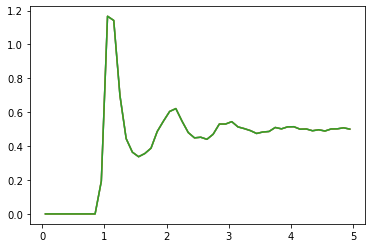

In [22]:
import matplotlib.pyplot as plt

plt.plot(rdf_frame[0][0], rdf_avg_10)
plt.plot(rdf_frame[0][0], rdf_avg_100)
plt.plot(rdf_frame[0][0], rdf_avg_1000)

In [25]:
[rdf_avg_10[i] - rdf_avg_100[i] for i in range(len(rdf_avg_10))]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.608224830031759e-16,
 4.440892098500626e-16,
 -1.5543122344752192e-15,
 6.661338147750939e-16,
 4.440892098500626e-16,
 5.551115123125783e-16,
 5.551115123125783e-16,
 -6.661338147750939e-16,
 8.326672684688674e-16,
 5.551115123125783e-16,
 -8.881784197001252e-16,
 1.1102230246251565e-16,
 0.0,
 3.3306690738754696e-16,
 -4.996003610813204e-16,
 -1.6653345369377348e-16,
 -1.1102230246251565e-16,
 -7.771561172376096e-16,
 -3.885780586188048e-16,
 0.0,
 9.992007221626409e-16,
 -9.992007221626409e-16,
 -4.440892098500626e-16,
 1.1102230246251565e-15,
 -6.106226635438361e-16,
 1.1102230246251565e-16,
 -3.3306690738754696e-16,
 -6.106226635438361e-16,
 -1.2212453270876722e-15,
 -8.881784197001252e-16,
 -8.881784197001252e-16,
 -5.551115123125783e-16,
 1.0547118733938987e-15,
 4.440892098500626e-16,
 -5.551115123125783e-16,
 -9.43689570931383e-16,
 9.992007221626409e-16,
 -2.220446049250313e-16,
 7.771561172376096e-16,
 4.44089209850062